In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Import with pandas 
import pandas as pd
import tensorflow as tf
import datetime

In [62]:
# Parse dates and set date column to index
df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv",
                 dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32'}, 
                 parse_dates=["date"], 
                 infer_datetime_format=True) # parse the date column (tell pandas column 1 is a datetime)

print(df.head())

#test
test_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv', parse_dates=['date'])

   id       date store_nbr      family  sales  onpromotion
0   0 2013-01-01         1  AUTOMOTIVE    0.0            0
1   1 2013-01-01         1   BABY CARE    0.0            0
2   2 2013-01-01         1      BEAUTY    0.0            0
3   3 2013-01-01         1   BEVERAGES    0.0            0
4   4 2013-01-01         1       BOOKS    0.0            0


In [63]:
# Find the total sales per day
total_sales = df.groupby('date').sum().squeeze()
total_sales = total_sales.reindex(pd.date_range(datetime.datetime(2013,1,1), datetime.datetime(2017,8,15), freq='D'), fill_value=0)
total_sales.head()

,id,sales,onpromotion
2013-01-01,1586871,2511.618896,0
2013-01-02,4762395,496092.406250,0
2013-01-03,7937919,361461.218750,0
2013-01-04,11113443,354459.687500,0
2013-01-05,14288967,477350.125000,0


In [64]:
df = pd.DataFrame({
    'date': total_sales.index,
    'value': total_sales['sales']
})

df.head()

,date,value
2013-01-01,2013-01-01,2511.618896
2013-01-02,2013-01-02,496092.406250
2013-01-03,2013-01-03,361461.218750
2013-01-04,2013-01-04,354459.687500
2013-01-05,2013-01-05,477350.125000


In [65]:
# function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Date")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

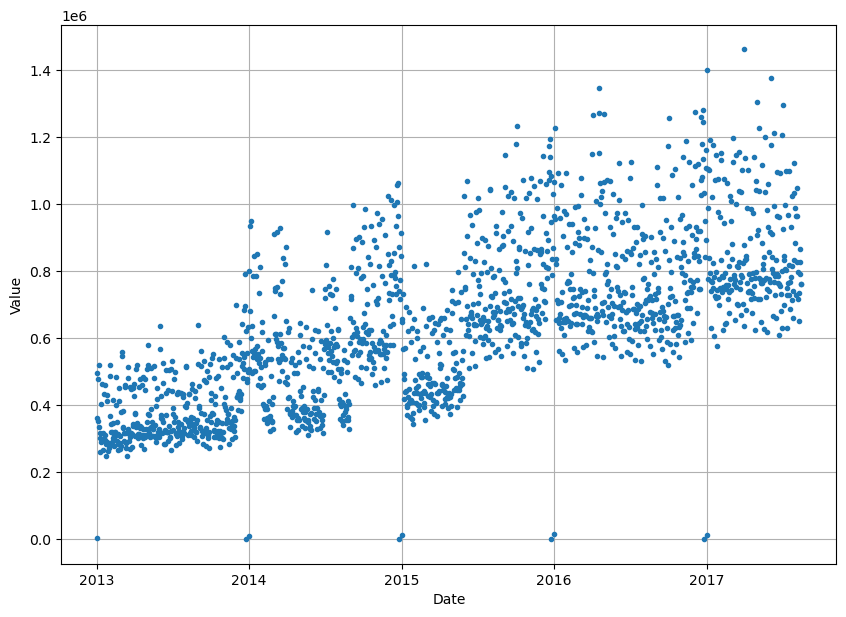

In [66]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=df['date'], values=df['value'])

In [67]:
timesteps=df['date']
prices=df['value']
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) 

(1350,) (338,) (1350,) (338,)


In [68]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

print(len(X_train), len(X_test), len(y_train), len(y_test))

1350 338 1350 338


In [69]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}


HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon
prices = df['value'].to_numpy()
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
    return x[:, :-horizon], x[:, -horizon:]
"""
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
"""
  
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
print(len(full_windows), len(full_labels))

# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
print(len(train_windows), len(test_windows), len(train_labels), len(test_labels))

# Check to see if same (accounting for horizon and window size)
print(np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:]))

import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

Window: [1 2 3 4 5 6 7] -> Label: 8
1681 1681
Window: [  2511.619 496092.4   361461.22  354459.7   477350.12  519695.4
 336122.8  ] -> Label: [318347.78]
Window: [496092.4  361461.22 354459.7  477350.12 519695.4  336122.8  318347.78] -> Label: [302530.8]
Window: [361461.22 354459.7  477350.12 519695.4  336122.8  318347.78 302530.8 ] -> Label: [258982.]
Window: [1049559.1   797464.94  717766.4   734139.7   651386.94  826373.75
  792630.56] -> Label: [865639.7]
Window: [797464.94 717766.4  734139.7  651386.94 826373.75 792630.56 865639.7 ] -> Label: [760922.4]
Window: [717766.4  734139.7  651386.94 826373.75 792630.56 865639.7  760922.4 ] -> Label: [762661.94]
1344 337 1344 337
False


In [70]:
# Construct model 1
import tensorflow as tf
from tensorflow import keras
from keras import layers
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model1_hist=model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=50,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

model_1.evaluate(test_windows, test_labels)

Epoch 1/50
11/11 [==============================] - 2s 75ms/step - loss: 444146.9062 - mae: 444146.9062 - val_loss: 293377.4375 - val_mae: 293377.4375
Epoch 2/50
11/11 [==============================] - 1s 57ms/step - loss: 141492.6250 - mae: 141492.6250 - val_loss: 209871.2188 - val_mae: 209871.2188
Epoch 3/50
11/11 [==============================] - 0s 47ms/step - loss: 143462.2812 - mae: 143462.2812 - val_loss: 162357.9062 - val_mae: 162357.9062
Epoch 4/50
11/11 [==============================] - 0s 47ms/step - loss: 111565.0156 - mae: 111565.0156 - val_loss: 155730.2500 - val_mae: 155730.2500
Epoch 5/50
11/11 [==============================] - 1s 81ms/step - loss: 103461.7344 - mae: 103461.7344 - val_loss: 138499.4844 - val_mae: 138499.4844
Epoch 6/50
11/11 [==============================] - 1s 50ms/step - loss: 98322.2734 - mae: 98322.2734 - val_loss: 134077.8594 - val_mae: 134077.8594
Epoch 7/50
11/11 [==============================] - 0s 48ms/step - loss: 93533.1016 - mae: 93533

[83703.703125, 83703.703125]

In [71]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return 1D array of predictions

# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_1_preds)
model_1_results

11/11 [==============================] - 0s 2ms/step


{'mae': 83703.71,
 'mse': 20597010000.0,
 'rmse': 143516.58,
 'mape': 3564960500000.0,
 'mase': 0.50698906}

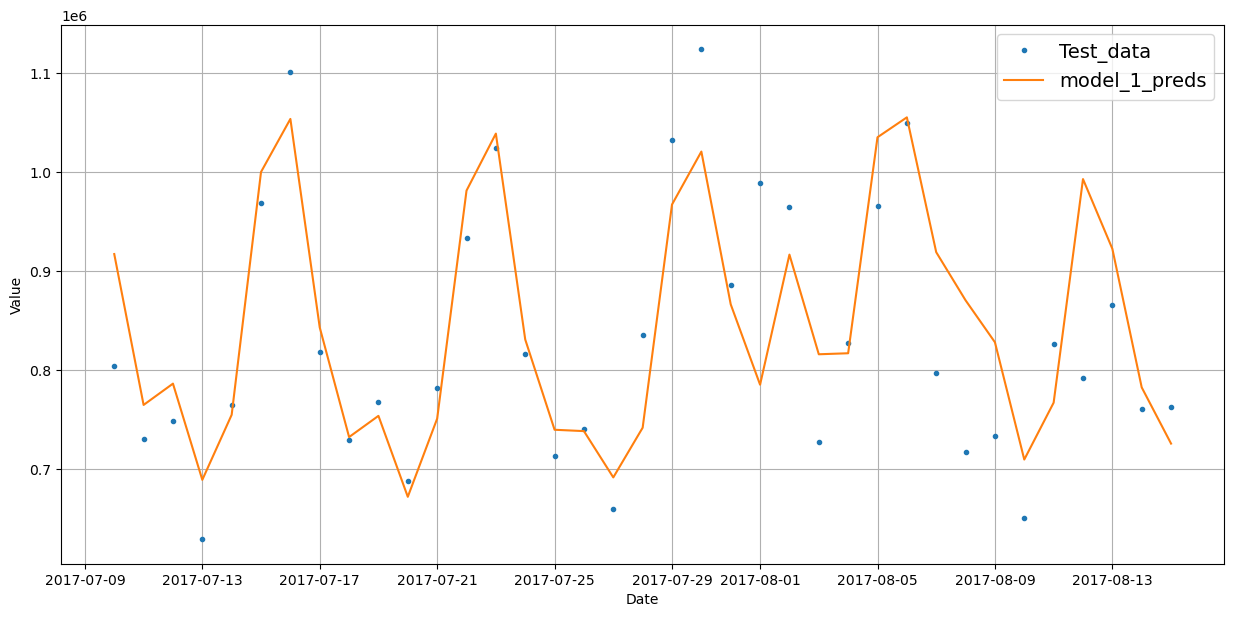

In [72]:
plt.figure(figsize=(15, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

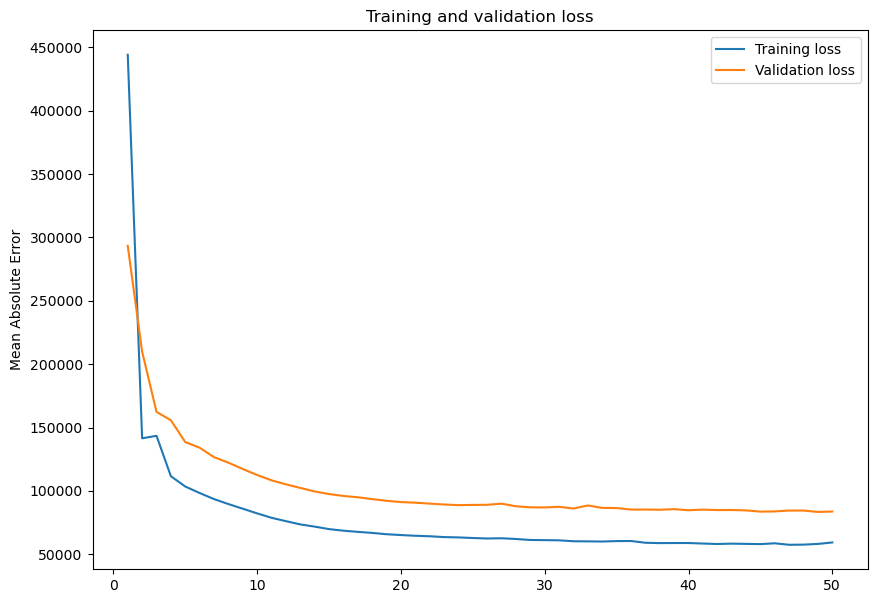

In [73]:
# visualize the loss
loss = model1_hist.history['loss']
val_loss = model1_hist.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [33]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
print(len(full_windows), len(full_labels))
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past



1658 1658


In [34]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
print(len(train_windows), len(test_windows), len(train_labels), len(test_labels))
tf.random.set_seed(42)


1326 332 1326 332


In [78]:
#MODEL 2
# Create model (same model as model 1 but data input will be different)
tf.random.set_seed(50)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model2_hist=model_2.fit(train_windows,
            train_labels,
            epochs=50,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])
model_2.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 2ms/step - loss: 82217.8359


82217.8359375

In [79]:
model_2_preds = make_preds(model_2,input_data=test_windows)
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_2_preds) # remove 1 dimension of test labels
model_2_results

11/11 [==============================] - 0s 2ms/step


{'mae': 82217.83,
 'mse': 19596493000.0,
 'rmse': 139987.47,
 'mape': 3419205000000.0,
 'mase': 0.49798915}

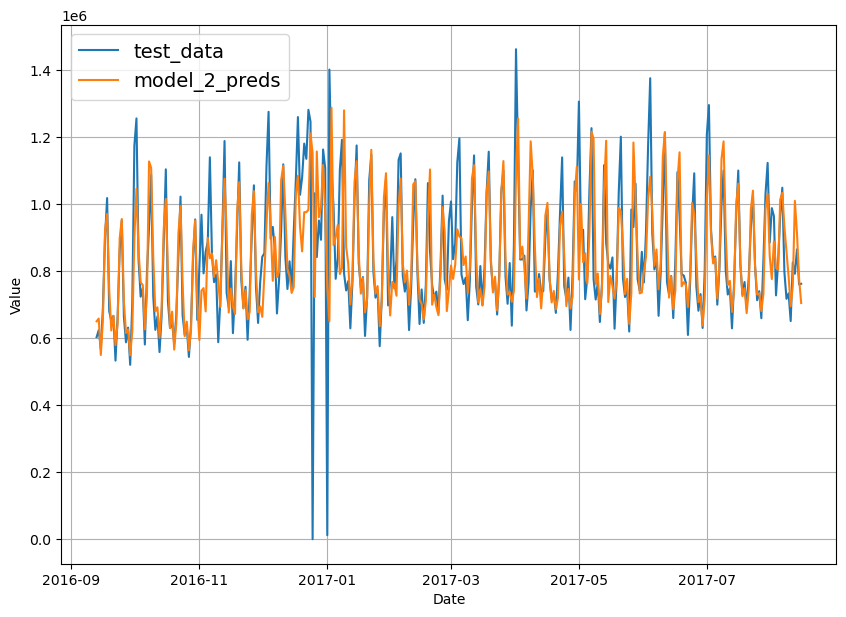

In [87]:
# Graphs for Model 2
offset = 0
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset,format='-', label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start= offset,format="-", label="model_2_preds")



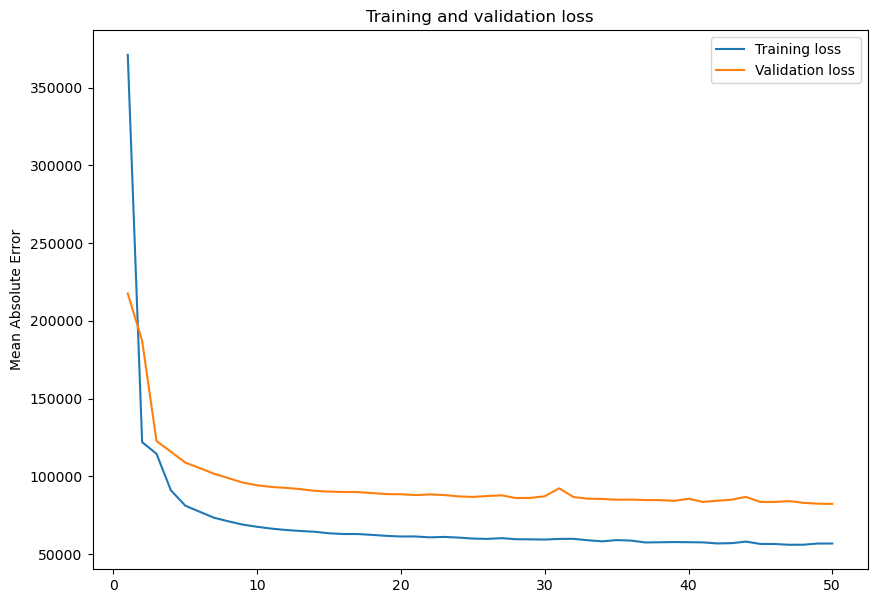

In [81]:
# visualize the loss
loss = model2_hist.history['loss']
val_loss = model2_hist.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [89]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
print(len(full_windows), len(full_labels))
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
print(len(train_windows), len(test_windows), len(train_labels), len(test_labels))

tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)


1652 1652
1321 331 1321 331
11/11 [==============================] - 0s 2ms/step - loss: 88503.5469


88503.546875

In [90]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,input_data=test_windows)
model_3_preds[:5]

# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

11/11 [==============================] - 0s 2ms/step


{'mae': array([ 61712.91 ,  38527.793,  29479.83 ,  34967.688,  36165.555,
         39094.707,  42425.555,  25200.59 ,  19530.188,  23294.562,
         19704.594,  17937.566,  57448.87 ,  96387.89 , 116576.914,
        120600.29 , 130678.81 , 129556.86 , 128969.07 ,  55972.34 ,
         51340.508,  54175.668,  45927.258,  38276.32 ,  34524.723,
         42211.285,  39457.75 ,  47479.062,  35013.098,  43245.57 ,
         56949.242,  49706.895,  43732.723,  33578.195,  51329.605,
         32724.232,  23750.482,  38609.805,  28501.535,  50869.285,
         30994.732,  31007.51 ,  38966.543,  51327.895, 111140.64 ,
        139074.58 , 168946.42 , 163915.34 , 177710.33 , 193433.05 ,
        127743.914,  64516.758,  57262.848,  61398.457,  52335.48 ,
         51514.785,  55781.652,  60556.223,  58011.438,  63699.355,
         53511.91 ,  56905.242,  54694.27 ,  32906.855,  29215.705,
         44587.945,  30854.393,  32050.205,  40502.152,  31929.178,
         33777.055,  38101.41 ,  40056.08

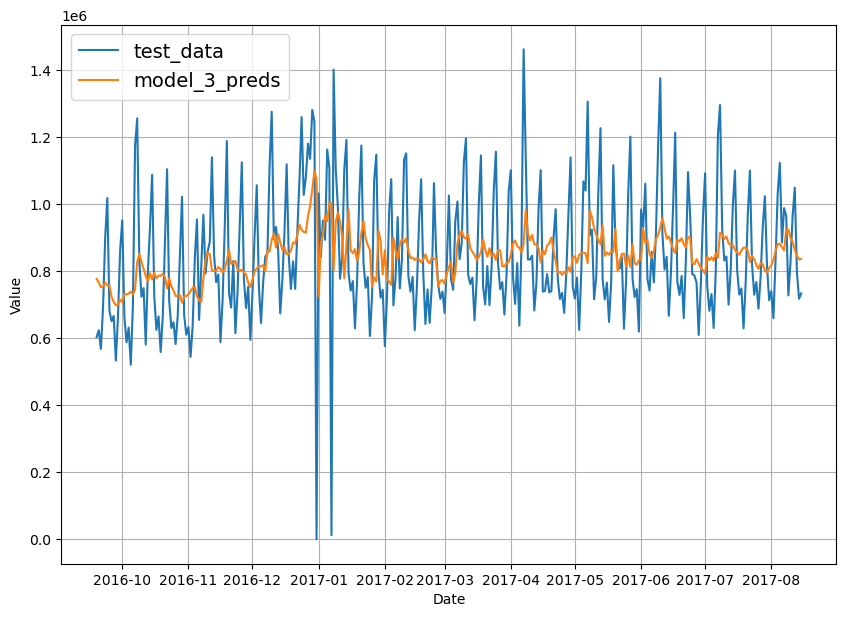

In [91]:
# Graph for Model 3
offset = 0
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, format='-', label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds,axis=1), start=offset, format="-", label="model_3_preds")
